# Backtest 

This backtest includes four parts  

1. Data exploration
2. Signal construction
3. Backtest and evaluation
4. Summary

In [1]:
# setup
%matplotlib inline
import math
import pandas as pd
import seaborn as sns
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from scipy.stats import mstats

# 1. Global hyper-parameters

# percentage of stocks to long or short at a time in a cross-sectional strategy
LONG_SHORT_THRESHOLD = 0.3
# skip if the number of valid cross-sectional stocks is fewer - this mitigates portfolio concentration
MIN_STOCKS = 20
# filter stocks by amount, i.e., price * volume > one million - mitigate trading stocks that are illquid or subject to price manipulation
INACTIVE_TRADING_AMOUNT = 1000000

## load data 
technical = pd.read_csv('https://raw.githubusercontent.com/scmqtest/data/main/technical.csv')
refdata = pd.read_csv('https://raw.githubusercontent.com/scmqtest/data/main/refdata.csv')
fundamental = pd.read_csv('https://raw.githubusercontent.com/scmqtest/data/main/fundamental.csv')

print(technical.shape, refdata.shape, fundamental.shape)

(142627, 6) (200, 3) (2291, 5)


## 1. Data exploration

Data exploration involves three steps:
1. check data types and transform format
2. check empty and missing values 
3. detect outliers 

### 1.1 check data types and transform format

In [2]:
technical.head(3)

,id,date,px_raw,px_adj,vlm_adj,beta
0,7203,2020-01-06,7565.0,1513.0,33362500.0,0.737115
1,6758,2020-01-06,7420.0,7420.0,5154100.0,0.592054
2,9437,2020-01-06,3031.0,3031.0,3883800.0,0.012950


In [3]:
technical.dtypes  # data types are consistent with my obersvation

id           int64
date        object
px_raw     float64
px_adj     float64
vlm_adj    float64
beta       float64
dtype: object

In [4]:
refdata.head(3)

,id,mktcap,gics
0,7203,29570914.77,Consumer Discretionary
1,9432,13626011.61,Communication Services
2,6758,12654955.67,Consumer Discretionary


In [5]:
refdata.dtypes  # consistent too

id          int64
mktcap    float64
gics       object
dtype: object

In [6]:
fundamental.head(3)    

,id,date,eps,revenue,capex
0,6146,2020-01-24,58.754232,34435.0,NaN
1,6146,2020-06-26,76.729069,38785.0,NaN
2,6146,2020-07-29,59.968501,35654.0,NaN


In [7]:
fundamental.dtypes # consistent too

id           int64
date        object
eps        float64
revenue    float64
capex      float64
dtype: object

The give data all have data types consistent with my expectation. The next step is to reset their indexes and add the column shares outstanding to the reference data.
I assume that shares outstanding does not change too much across three years so that market cap can be computed by shares outstanding and recent price as per trade.

In [8]:
# use ticks to replace dates for easier programming
# for example, getting past 20 days only need loc[cur_tick-20:cur_tick-1]
calendar = technical.date.unique()
calendar_map = {date: i for i, date in enumerate(calendar)}
technical['tick'] = technical.date.transform(lambda x: calendar_map[x])
technical.set_index(['tick', 'id'], inplace=True)
refdata.set_index('id', inplace=True)
fundamental.set_index(['id', 'date'], inplace=True)

# drop unused rows
unused_stocks = refdata.index.difference(technical.index.get_level_values('id'))
refdata.drop(unused_stocks, inplace=True)
# ensure id is consistent in the three kinds of data
assert (refdata.index == refdata.index.get_level_values("id")).all()

# compute shares outstanding
last_tick = technical.index.get_level_values('tick')[-1]
price_data = technical.groupby(level='id').apply(lambda x: x.px_adj.iloc[-1])
refdata['shares'] = refdata.mktcap / price_data

### 1.2 Check empty and missing values 

In [9]:
technical.isnull().sum()

date       0
px_raw     0
px_adj     0
vlm_adj    0
beta       0
dtype: int64

In [10]:
refdata.isnull().sum()

mktcap    0
gics      0
shares    0
dtype: int64

In [11]:
fundamental.isnull().sum() 

eps          1
revenue      0
capex      980
dtype: int64

Drop the column capex as it contains too many null values and aksi is not a required field for this backtest.
The eps column contains one null value, but there seems no accurate way to fill the gap.

In [12]:
fundamental.drop('capex', axis=1, inplace=True)

The next step is to count each stock's non-null price data.
Drop the stocks that have too few data.

In [13]:
(~technical.px_adj.unstack(level='id').isnull()).sum().loc[lambda x:x<1/2*(252*3)] 

id
3938    243
4217    111
4508     34
8028    215
8036     86
8729    160
9437    241
dtype: int64

Only a few stock have less than half data. my choice is to keep not to drop them since the data size is acceptable.
However even if a stock has enough non-null price data, it does not mean the price data is good, because there could be many gaps.
For example, a stock may be listed for two years, but there are many gaps in the period.

In [14]:
def price_over_missing(data, threshold):
    tmp = data[~data.isnull()]
    ticks = tmp.index.get_level_values(0)
    if len(ticks) /(ticks.max()-ticks.min())< threshold:
        return False 
    return True 
len(technical.px_adj.groupby(level='id').apply(price_over_missing, 0.9).loc[lambda x:x==0])

0

In [15]:
len(technical.px_adj.groupby(level='id').apply(price_over_missing, 0.95).loc[lambda x:x==0])

86

As shown above, most stocks have continous data. For missing values in the continous period, an option is to fill each gap with previous values.
I did not do so since the strategy I tested could be short-run. I wanted to avoid the influence of price change.

I merely checked each stock's price data here because it influences our computation for returns. 
In practice, if our signal heavily relies on other data, e.g., volume, we may need to examine they as well. 

### 1.3 Detect outliers

I used mean-3\*std and mean+3\*std as the lower bound and upper bound to detect outliers. 
I only checked price and volume data since the data are sufficient and they are less likely to fall out of the range.  

In [16]:
# as shown abov# check outliers for technical data using mean-3*std and mean+3*std as lower bound and upper bound
# unable to detect outliers for fundamental and reference data due to insufficient data
def tech_outlier_exist(data: pd.Series):
    interval = 10  # 10 trading days
    for i in range(math.ceil(len(data) / interval)):
        s = i * interval
        e = min(len(data), (i + 1) * interval)
        if e - s < interval:
            s = e - interval
        if s < 0:
            print("not able to judge for insufficient data")
            return False
        tmp = data.iloc[s:e]

        mean = tmp.mean()
        std = tmp.std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        if ((tmp < lower_bound) | (tmp > upper_bound)).any(axis=None):
            return True
    return False


print(technical.vlm_adj.groupby(level='id').apply(tech_outlier_exist).any()) 
print(technical.px_adj.groupby(level='id').apply(tech_outlier_exist).any())  

False
False


There seems no outliers. If so, better to check if the price is reasonable first before removing the data

## 2. Signal construction

The signal is constructed by combing four factors. This section includes two parts.

1. Factor construction 
2. Signal construction

## 2.1 Factor construction

Four factors including, ema/price, pe ratio, value, BBI momentum.

1. ema/price = N-days exponential moving average/previous price
2. pe/ratio = previous price/eps 
3. value = log2(market cap)
4. BBI momentum = BBI(3,6,12,24)/previous price, among which BBI(3,6,12,24)=(avg_price(3)+avg_price(6)+avg_price(12)+avg_price(24))/4

In [17]:
# an indicator(aka. factor) interface
class Indicator:
    def __str__(self):
        raise NotImplementedError("str function not implemented")

    def value(self, cur_tick, **kwargs):  # return factor values for stocks
        raise NotImplementedError("value function not implemented")


# Following are the definition of four factors
# Factors are binarized when combined, so pre-processing such as normalization is not necessary
# exponential moving average divded by the previous close price
class EMADivPrice(Indicator):
    def __init__(self, lookback):
        self.lookback = lookback

    def __str__(self):
        return f'{self.lookback}-days ema/price'

    def eval(self, techdata: pd.DataFrame):
        if len(techdata) < self.lookback:
            return np.nan
        ema = 0
        for i in range(len(techdata)):
            ema = 2 * techdata.iloc[i].px_adj / (self.lookback + 1) + (self.lookback - 1) * ema / (self.lookback + 1)
        return ema / techdata.iloc[-1].px_adj

    def value(self, cur_tick, **kwargs):
        technical = kwargs['technical']
        techdata = technical.loc[max(cur_tick - 1 + 1 - self.lookback, 0): cur_tick - 1]  # loc range is inclusive
        return techdata.groupby(level='id').apply(lambda x: self.eval(x))


# price to earning ratio
class PERatio(Indicator):
    def __str__(self):
        return f'PE ratio'

    def eval(self, row, cur_date, fundamental):
        eps = fundamental.query(f"id=={row.id} and date<'{cur_date}'").eps
        if len(eps) == 0:
            return np.nan
        eps = eps.iloc[-1]
        return row.px_adj / eps

    def value(self, cur_tick, **kwargs):
        tick_date_map = kwargs['tick_date_map']
        cur_date = tick_date_map[cur_tick]
        technical = kwargs['technical']
        fundamental = kwargs['fundamental']
        price_data = technical.loc[cur_tick - 1, 'px_adj'].copy()
        price_data.loc[:] = price_data.reset_index().apply(lambda row: self.eval(row, cur_date, fundamental), axis=1)
        return price_data


# use log-normalized market cap as value
class Value(Indicator):
    def __str__(self):
        return f'value=log2(mktcap)'

    def value(self, cur_tick, **kwargs):
        technical = kwargs['technical']
        shares = kwargs['refdata'].shares
        price_data = technical.loc[cur_tick - 1, 'px_adj'].copy()
        price_data.loc[:] = price_data.reset_index().apply(lambda x: x.px_adj * shares.loc[x.id], axis=1)
        val = np.log2(price_data)
        return val


# BBI(3,6,12,24)/price
# BBI(3,6,12,24) is the average of 3-days avg. price, 6-days, and so
class BBIMomentum(Indicator):

    def __str__(self):
        return f'BBI(3,6,12,24)/price'

    def eval(self, techdata: pd.DataFrame):
        if len(techdata) < 24:
            return np.nan
        avg_price_3 = techdata.iloc[-3:].px_adj.mean()
        avg_price_6 = techdata.iloc[-6:].px_adj.mean()
        avg_price_12 = techdata.iloc[-12:].px_adj.mean()
        avg_price_24 = techdata.iloc[-24:].px_adj.mean()
        return (avg_price_3 + avg_price_6 + avg_price_12 + avg_price_24) / 4 / techdata.iloc[-1].px_adj

    def value(self, cur_tick, **kwargs):
        technical = kwargs['technical']
        techdata = technical.loc[max(cur_tick - 1 + 1 - 24, 0): cur_tick - 1]
        return techdata.groupby(level='id').apply(lambda x: self.eval(x))

## 2.2 Signal construction

Combine factors to form a signal. 
First, each factor's value is binarized to mitigate the bias of a single factor. For each factor, stocks are first sorted by the factor values in descending order. Top-30% stocks are scored by 1. Bottom-30% stocks are scored by -1. The remaining are scored by 0. Note that a stock having a null factor value has a null score. 
Then, a stock's finally score is computed by summing all scores. Note that if a stock's all factor values are null, the stock won't be considered for trading at the moment.
Later in the backtest, long top-30% stocks and short bottom-30% stocks.

In [18]:
class Signal:
    def __init__(self, indicators: List[Indicator]):
        self.indicators = indicators

    def value(self, cur_tick: int, **kwargs):
        values = []
        for ind in self.indicators:
            val = ind.value(cur_tick, **kwargs)
            non_null_val = val[~val.isnull()]
            non_null_val.sort_values(ascending=False)
            if len(non_null_val) >= MIN_STOCKS:
                long_num = int(len(non_null_val) * LONG_SHORT_THRESHOLD)
                short_num = int(len(non_null_val) * LONG_SHORT_THRESHOLD)
                val.loc[non_null_val[:long_num].index] = 1
                val.loc[non_null_val[-short_num:].index] = -1
                val.loc[non_null_val[long_num:-short_num].index] = 0
            val.name = str(ind)
            values.append(val)
        values = pd.DataFrame(values).T  #
        # sum all factor values
        # the function sum() by default skip nan values
        # but I want to retain nan values if a stock's all factors values are nan
        # this helps filter stocks
        return values.apply(lambda x: x.sum() if not x.isna().all() else np.nan, axis=1)

## 3. Backtest and evaluation

### 3.1 Methodology

#### Backtest 
The main logic is included in the function run. (each tick stands for a single trading day)
Every period, rebalance portfolio if there are more than 20 tradable stocks at cross-section. 
A stock is tradable if its all factor values are not null, if its recent trading amount is more than 1 million and if its price data is not missing. 
Stocks are first sorted by their signal values.
The new portfolio is then chosen by long top 30% and short botttom 30%.
Stocks are next weighted by market caps, which are first applied log2 and then winsorized by capping top 5% and bottom 5%.
The weights are further adjusted according to the beta of top 30% and that of bottom 30%, to make the final beta zero.
I used the variable self.trading_history to record each trade for computing evaluation metrics. 

#### Evaluation
Evaluation includes the following 7 metrics. Note that transaction fees are considered and are set to to 3bp in this backtest.
1. Cumulative return
2. Annual sharp ratio
3. Return on trades: the average profit on each trade
4. Number of trades
5. Transaction cost: transaction fees/intial asset
6. Max drawdawn
7. Average turnover

In [19]:
# backtest
# main logic happens in the function run
class BackTest:
    def __init__(self, period: int, fee_rate: float = 0):
        # adjust portfolio by period
        self.period = period  # the period to adjust portfolio
        self.fee_rate = fee_rate
        self.trading_history = []  # record each trade

    def register_data(self, technical: pd.DataFrame, fundamental: pd.DataFrame, refdata: pd.DataFrame):
        self.technical = technical
        self.fundamental = fundamental
        self.refdata = refdata
        self.tick_num = technical.index.get_level_values('tick').nunique()
        trading_calendar = technical.date.unique()
        self.tick_date_map = {i: date for i, date in enumerate(trading_calendar)}

    def register_signal(self, signal: Signal):
        self.signal = signal

    def run(self):
        trading_history = []
        for cur_tick in range(1, self.tick_num):
            # portfolio are periolly adjusted to reduce risk.
            # ideally, under-performed stocks are swapped out
            if (cur_tick + 1) % self.period != 0:
                continue

            # compute signal for stocks
            val = self.signal.value(cur_tick, technical=self.technical, fundamental=self.fundamental,
                                    refdata=self.refdata, tick_date_map=self.tick_date_map)
            non_null_val = val[~val.isnull()]  # filter stocks that don't have any valid factors

            # skip stocks that miss price data or have been delisted
            # skip the stocks miss current-date data, cuz I use the close price as buy price
            # skip may be better for a short-run strategy, since price change in a few days could matter a lot
            missing_stocks = non_null_val.index.difference(self.technical.loc[cur_tick].index)
            non_null_val.drop(missing_stocks, inplace=True)
            # in the following, will first use latest trading amount to filter inactive stocks
            # then use market cap to construct weighted portfolio
            # here, these metrics are not that sensitive to price variation. So use previous data to fill missing values
            missing_stocks = non_null_val.index.difference(self.technical.loc[cur_tick - 1].index)
            techdata = self.technical.loc[(cur_tick - 1, non_null_val.index.difference(missing_stocks)), :]
            for stock in missing_stocks:
                c = 2
                while (cur_tick - c, stock) not in self.technical.index:
                    c += 1
                    assert cur_tick - c >= 0, f"stock {stock} may miss too many data"
                techdata[(cur_tick, stock)] = self.technical.loc[(cur_tick - c, stock)]
            techdata = techdata.droplevel('tick')

            # filter inactive stocks
            non_null_val = non_null_val[techdata.px_adj * techdata.vlm_adj > INACTIVE_TRADING_AMOUNT]
            if len(non_null_val) < MIN_STOCKS:
                # print(f"no enough valid stocks at tick {cur_tick}")
                continue

            # long top and short bottom
            new_position = []
            non_null_val.sort_values(ascending=False, inplace=True)
            universe_size = len(non_null_val)
            top = non_null_val.index[:int(universe_size * LONG_SHORT_THRESHOLD)]
            bottom = non_null_val.index[-int(universe_size * LONG_SHORT_THRESHOLD):]

            # market cap weighting + market-neutral strategy
            # stocks are first weighted by market cap
            # then the weights of long and short positions are adjusted to make total beta zero
            price_data = techdata.px_adj
            # market cap is normalized and winsorized
            mktcap = self.refdata.loc[price_data.index, 'shares'] * price_data
            mktcap = np.log2(mktcap)
            mktcap[:] = mstats.winsorize(mktcap, limits=[0.05, 0.05])  # avoid the impact of extreme value
            beta_top = self.technical.loc[(cur_tick - 1, top), 'beta']
            beta_top = beta_top.droplevel('tick')
            beta_bottom = self.technical.loc[(cur_tick - 1, bottom), 'beta']
            beta_bottom = beta_bottom.droplevel('tick')
            mktcap_top = mktcap.loc[top]
            mktcap_bottom = mktcap.loc[bottom]
            mktcap_weighted_beta_top_sum = (mktcap_top * beta_top).sum()
            mktcap_weighted_beta_bottom_sum = (mktcap_bottom * beta_bottom).sum()
            if mktcap_weighted_beta_top_sum * mktcap_weighted_beta_bottom_sum <= 0:
                print(f"tick {cur_tick}: unable to reach neutral")
                continue
            total_weight = 0
            for stock in top:
                weight = mktcap_weighted_beta_bottom_sum * mktcap_top.at[stock]
                total_weight += weight
            for stock in bottom:
                weight = -mktcap_weighted_beta_top_sum * mktcap_bottom.at[stock]
                total_weight += -weight
            for stock in top:
                weight = mktcap_weighted_beta_bottom_sum * mktcap_top.at[stock] / total_weight
                new_position.append((cur_tick, stock, weight))
            for stock in bottom:
                weight = -mktcap_weighted_beta_top_sum * mktcap_bottom.at[stock] / total_weight
                new_position.append((cur_tick, stock, weight))

            new_position = pd.DataFrame(new_position, columns=["tick", "id", "weight"])
            new_position.set_index(["tick", "id"], inplace=True)
            trading_history.append(new_position)
        self.trading_history = pd.concat(trading_history) if len(trading_history) > 0 else pd.DataFrame()

    def analyze(self, plot=False):
        # compute statistics according to trading history
        trading_history = self.trading_history
        if len(trading_history) <= 1:
            print("length of trading history less than 2, skip analysis")
            return pd.Series()
        trade_ticks = trading_history.index.get_level_values('tick').unique()
        # returns
        rets_no_tx_fee = self.__rets_no_tx_fee()  # a series of returns on trades without considering tx fees
        # consider tx fees
        turnovers = self.__turnovers()
        asset = 1  # assuming total asset is 1
        transac_cost = 0
        rets = []
        for i in range(len(trade_ticks) - 1):
            transac_cost += asset * 2 * turnovers[i] * self.fee_rate
            ret = (1 - 2 * turnovers[i] * self.fee_rate) * (rets_no_tx_fee[i]+1) - 1
            asset = asset * (ret+1) 
            rets.append(ret)
        rets = np.array(rets)

        # compute max drawdown
        cum_rets = (rets + 1).cumprod()
        max_ret = -1
        max_draw_dawn = 0
        for ret in cum_rets:
            if ret > max_ret:
                max_ret = ret
            max_draw_dawn = max(max_draw_dawn, (max_ret - ret) / max_ret)
        
        #plot cumulative return if necessary
        if plot:
            sns.set(rc={'figure.figsize': (12, 5)})
            dots_num = 8 # 8 or 9
            interval = max(1,(len(trade_ticks) - 1)//dots_num)
            plot_dates = []
            plot_cum_rets = []
            for i in range(len(trade_ticks)-1):
                if i%interval==0 or i==len(trade_ticks)-2:
                    plot_dates.append(self.tick_date_map[trade_ticks[i]])
                    plot_cum_rets.append(cum_rets[i])
            sns.lineplot(pd.DataFrame(plot_cum_rets, index=plot_dates))
            plt.title("cumulative return vs date")
            plt.legend('')
            plt.show()
        
        statistics = pd.Series()
        statistics['cum return'] = (rets + 1).prod() - 1
        statistics['annual sharp ratio'] = rets.mean() / rets.std() * (252 / self.period) ** 0.5
        statistics['return on trade'] = rets.mean()
        statistics['number of trades'] = len(trade_ticks)
        statistics['transac cost'] = transac_cost
        statistics['max drawdown'] = max_draw_dawn
        statistics['average turnover'] = turnovers.mean()
        return statistics

    def __rets_no_tx_fee(self):
        trading_history = self.trading_history
        # returns
        rets = []
        trade_ticks = trading_history.index.get_level_values('tick').unique()
        for i in range(len(trade_ticks) - 1):
            cur_tick = trade_ticks[i]
            next_tick = trade_ticks[i + 1]
            stocks = trading_history.loc[cur_tick].index
            weights = trading_history.loc[cur_tick, 'weight']
            cur_price = self.technical.loc[(cur_tick, stocks), 'px_adj']
            cur_price = cur_price.droplevel('tick')

            # possible that stocks delisted or miss prices
            # use most recent price instead, assuming stocks sold earlier
            missing_stocks = stocks.difference(self.technical.loc[next_tick].index)
            next_price = self.technical.loc[(next_tick, stocks.difference(missing_stocks)), 'px_adj']
            for stock in missing_stocks:
                c = 0
                while (next_tick - c, stock) not in self.technical.index:
                    c += 1
                    assert c <= next_tick - cur_tick, "at worst the loop should stop at cur_tick"
                next_price[(next_tick, stock)] = self.technical.at[(next_tick - c, stock), 'px_adj']
            next_price = next_price.droplevel('tick')
            ret = ((next_price - cur_price) / cur_price * weights).sum()
            rets.append(ret)
        rets = np.array(rets)
        return rets

    def __turnovers(self):
        trading_history = self.trading_history
        trade_ticks = trading_history.index.get_level_values('tick').unique()
        turnovers = []
        for i in range(len(trade_ticks) - 1):
            cur_tick = trade_ticks[i]
            next_tick = trade_ticks[i + 1]
            cur_stocks = trading_history.loc[cur_tick]
            next_stocks = trading_history.loc[next_tick]
            common = cur_stocks.index.intersection(next_stocks.index)
            left = cur_stocks.index.difference(next_stocks.index)
            right = next_stocks.index.difference(cur_stocks.index)
            turnover = cur_stocks.loc[left].abs().sum() + next_stocks.loc[right].abs().sum() + (
                    cur_stocks.loc[common] - next_stocks.loc[common]).abs().sum()
            turnover = turnover / 2
            turnovers.append(turnover)
        turnovers = np.array(turnovers).reshape(-1)
        return turnovers

### 3.2 Test

First test all stocks and then test each sector.

First, test all stocks.

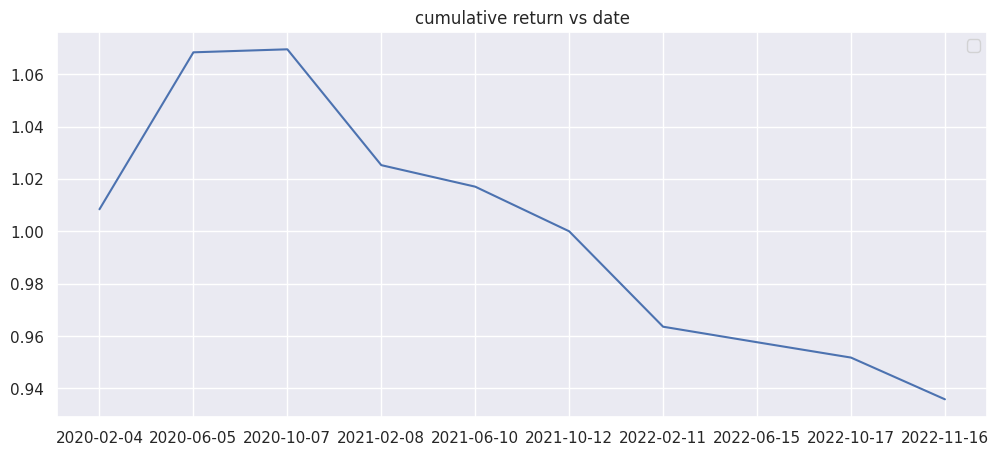

cum return            -0.064144
annual sharp ratio    -0.457256
return on trade       -0.001853
number of trades      35.000000
transac cost           0.007188
max drawdown           0.134773
average turnover       0.348961
Name: statistics, dtype: float64

In [20]:
def test(technical, fundamental, refdata, plot=False):
    period = 22
    backtest = BackTest(period, fee_rate=0.0003)
    backtest.register_data(technical, fundamental, refdata)

    ema_div_price = EMADivPrice(5)
    pe_ratio = PERatio()
    bbi_momentum = BBIMomentum()
    value = Value()
    indicators = [ema_div_price, pe_ratio, bbi_momentum, value]
    signal = Signal(indicators)
    backtest.register_signal(signal)

    backtest.run()
    return backtest.analyze(plot=plot)
    
statistics = test(technical, fundamental, refdata, plot=True)
statistics.name='statistics'
statistics

The strategy seems fine if traded in the opposite direction, while the turnover is still high. Despite that the result is still subject to overfitting or chance. Need to test more stocks and more data or perform out-of-sample test. 

Next test each sector, while only a few sectors have stocks more than 20 as shown below. 

In [21]:
refdata.gics.value_counts().loc[lambda x:x>=MIN_STOCKS]

gics
Industrials               44
Information Technology    27
Consumer Discretionary    26
Financials                21
Name: count, dtype: int64

In [22]:
def test_sector(technical, fundamental, refdata, sector):
    print(f'test sector {sector}')
    refdata = refdata[refdata.gics == sector]
    fundamental = fundamental.loc[(refdata.index, slice(None)), :]
    technical = technical.loc[(slice(None), refdata.index), :].copy()
    technical.sort_index(inplace=True)
    return test(technical, fundamental, refdata, plot=False)

# test by sector. only choose those have enough stocks.
sectors = (refdata.gics.value_counts() >= MIN_STOCKS).loc[lambda x: x].index
metrics = []
for sector in sectors:
    statistics = test_sector(technical, fundamental, refdata, sector)
    if len(statistics)!=0:
        statistics.name = sector
        metrics.append(statistics)
metrics = pd.DataFrame(metrics)

test sector Industrials
test sector Information Technology
test sector Consumer Discretionary
test sector Financials
length of trading history less than 2, skip analysis


In [23]:
metrics

,cum return,annual sharp ratio,return on trade,number of trades,transac cost,max drawdown,average turnover
Industrials,-0.169125,-0.780983,-0.005182,35.0,0.011121,0.239331,0.564381
Information Technology,-0.023860,-0.153491,-0.001838,10.0,0.002675,0.118293,0.500140
Consumer Discretionary,-0.071481,-0.504304,-0.003989,18.0,0.005008,0.122695,0.531723


The sector Financials is not listed for insufficient trading history. 
The strategy looks good in the sector Industrials and Consumer Discretionary if traded in opposite direction, while the turnover is still high, and the max drawdown for Industrials is also high. As stated before, the result is still subject to overfitting or chance.

## 4. Summary

The backtest result is still not ideal. There are still many works left to do, such as designing more factors, factor validity test, decent factor combination, sensitive test, porfolio optimization, etc.